In [1]:
from functions import *
import matplotlib.pyplot as plt
import pickle
from parameters_henry import *

Plot linear spectrum and exciting field:

In [2]:
with open('results/henry/Qdim=4000_Qmax=1.5_power0.0001_n_wells1_z20.0_reflectionsFalse_linear_grid_polarizations.pickle', 'rb') as input_file:
    pol_linear = pickle.load(input_file)[0]
abs_linear = get_absorption_SQW(pol_linear, t_c, tlist,omega_list,  np.pi*hbar/(d_cv)*0.0001, 200/(2*np.sqrt(np.log(2))), omega_0, n_medium, pulse_shape = 'gauss', method = '1-R-T')
E_w = fouriertrafo(gauss_pulse(tlist,np.pi*hbar/(d_cv)*0.0001, 200/(2*np.sqrt(np.log(2))), t_c), omega_list, tlist)

-0.008773773773773775


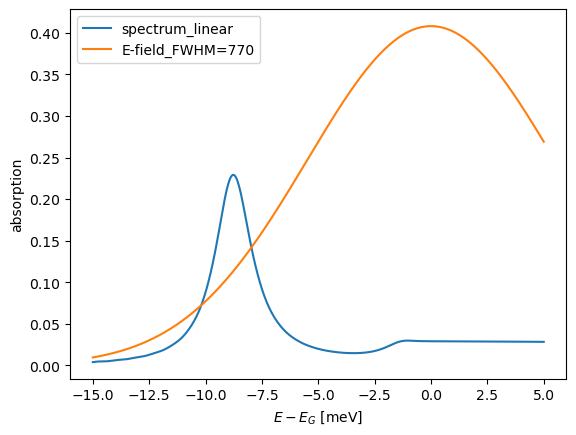

In [3]:
plt.plot(1000* hbar*(omega_list), abs_linear, label = 'spectrum_linear')
plt.plot(1000* hbar*(omega_list), 1500*np.abs(E_w), label = 'E-field_FWHM=770')
plt.ylabel('absorption')
plt.xlabel(r'$E-E_G$ [meV]')
plt.legend()
print(omega_list[np.argmax(abs_linear)]*hbar)

Reproduce fig. 2b

/usr/local/conda-20240828/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/conda-20240828/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


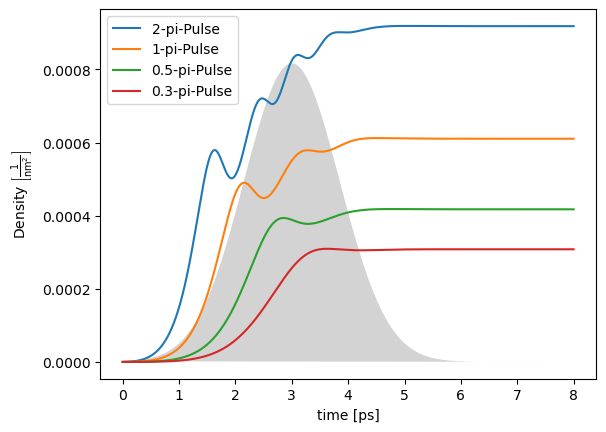

In [4]:
from parameters_henry import tlist
#crop data to pulse region
start = 0
end = len(tlist)
tlist_cropped = tlist[start:end]
plt.fill(tlist/1000,gauss_pulse(tlist,np.pi*hbar/(d_cv), sigma, t_c)**2*1000, 'lightgray')
for n in [2, 1, 0.5, 0.3]:
    with open('results/henry/Qdim=4000_Qmax=1.5_power{}_n_wells1_z20.0_reflectionsFalse_linear_grid_occupations.pickle'.format(n), 'rb') as input_file:
        nonlinear_coulomb = pickle.load(input_file)[0][start:end]
#with open('results/schuelzgen/Qdim=700_Qmax=1.5_power16_no_nonl_coulomb_pf_corr=9.0_n_wells1_z2500320.0_reflectionsFalse_quadratic_grid_occupations.pickle', 'rb') as input_file:
 #   linear_coulomb = pickle.load(input_file)[0][start:end]

    plt.plot(tlist/1000, nonlinear_coulomb,label = '{}-pi-Pulse'.format(n))
plt.xlabel('time [ps]')
plt.ylabel(r'Density $\left[\frac{1}{\text{nm}^2}\right]$')
plt.legend()
plt.savefig('results/henry/plots.pdf', bbox_inches = 'tight')

In [6]:
powers = [1.5, 2.5, 3, 3.5, 4]
for power in powers:
    with open('results/henry/Qdim=4000_Qmax=1.5_power{}with_gamma_R_n_wells1_z20.0_reflectionsFalse_linear_grid_occupations.pickle'.format(power), 'rb') as input_file:
        occupations = pickle.load(input_file)
    
    with open('results/henry/Qdim=4000_Qmax=1.5_power{}_n_wells1_z20.0_reflectionsFalse_linear_grid_occupations.pickle'.format(power), 'wb') as output_file:
        pickle.dump(occupations,output_file)

FileNotFoundError: [Errno 2] No such file or directory: 'results/henry/Qdim=4000_Qmax=1.5_power1.5with_gamma_R_n_wells1_z20.0_reflectionsFalse_linear_grid_occupations.pickle'

Next, we want to determine the Rabi frequencies at different field strengths, by measuring the time differences between the occupation maxima/minima and taking the smallest difference between two maxima/minima

In [7]:
#read N(t) arrays for different fluences and crop to approximate pulse duration:
occupations = []
powers = [0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
for power in powers:
    with open('results/henry/Qdim=4000_Qmax=1.5_power{}_n_wells1_z20.0_reflectionsFalse_linear_grid_occupations.pickle'.format(power), 'rb') as input_file:
        occupations.append(pickle.load(input_file)[0])
    

tlist = np.array(tlist)

# Combine tlist as the first column with the occupations data
combined_array = np.column_stack(np.real((tlist, *occupations)))

# Define the output file path
output_file = 'occupations_data_with_tlist_Qdim=4000.txt'

# Save the combined array as columns in a text file
header = "tlist\t" + "\t".join([f"Power_{p}" for p in powers])
np.savetxt(output_file, combined_array, delimiter='\t', header=header, comments='')


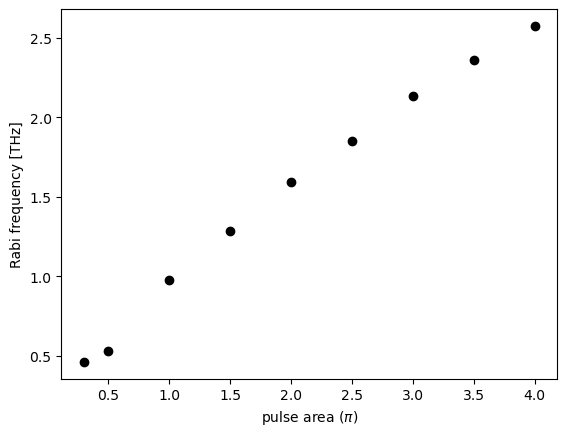

In [9]:
from scipy.signal import find_peaks
# find rabi frequencies from single shortest oscillation
rabi_frequencies = np.zeros_like(powers)
for i in range(len(powers)):
    maxima, _ = find_peaks(occupations[i], height=0)
    minima, _ = find_peaks(-occupations[i])
    tmax_list = tlist_cropped[maxima]
    tmin_list = tlist_cropped[minima]
    diffs_maxima = np.diff(tmax_list)
    diffs_minima = np.diff(tmin_list)
    rabi_frequencies[i] = 1/np.min(np.concatenate((diffs_maxima, diffs_minima)))*1e3

plt.scatter(powers, rabi_frequencies, c = 'black')
plt.xlabel(r"pulse area $(\pi)$")
plt.ylabel('Rabi frequency [THz]')

# Combine tlist as the first column with the occupations data
combined_array = np.column_stack((np.array(powers), np.array(rabi_frequencies)))

# Define the output file path
output_file = 'rabi_frequencies_Qdim=4000.txt'

# Save the combined array as columns in a text file
header = ("Power (pi)\t" + "\tRabi-frequency (THz)")
np.savetxt(output_file, combined_array, delimiter='\t', header=header, comments='')

/usr/local/conda-20240828/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
/usr/local/conda-20240828/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/conda-20240828/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


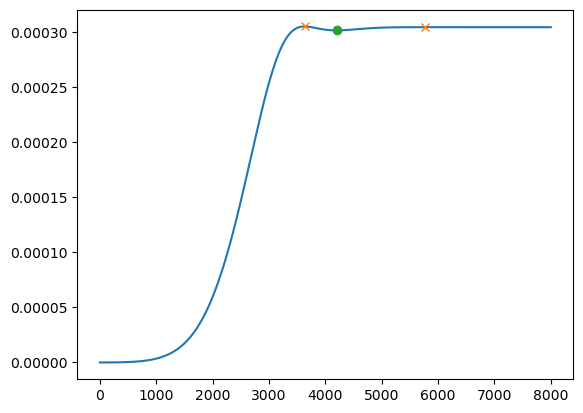

Times of maxima:  [3631.7 5772.6]
Times of minima:  [4200.4]
[2140.9]
[]
0.4670932785277221


In [5]:
from scipy.signal import find_peaks
# look for local maxima and return corresponding time values
i = 0
maxima, _ = find_peaks(occupations[i], height=0)
minima, _ = find_peaks(-occupations[i])
tmax_list = tlist_cropped[maxima]
tmin_list = tlist_cropped[minima]
plt.plot(tlist_cropped,occupations[i])
plt.plot(tmax_list, occupations[i][maxima], "x")
plt.plot(tmin_list, occupations[i][minima], "o")
plt.show()
print('Times of maxima: ', tmax_list)
print('Times of minima: ', tmin_list)
diffs_maxima = np.diff(tmax_list)
diffs_minima = np.diff(tmin_list)
print(diffs_maxima)
print(diffs_minima)
rabi_frequency = 1/np.min(np.concatenate((diffs_maxima, diffs_minima)))*1e3
print(rabi_frequency)

In [54]:
np.sqrt(0.68*float(16)*1*6.24157*1e-2*4*np.sqrt(np.pi)*sigma/(epsilon_0*c*n_medium))*d_cv/(hbar)/(np.sqrt(2*np.pi)*sigma)*1e3

4.604554789404039